#Fuzzy Controller Optimization

In [ ]:
!pip install scikit-fuzzy

     |████████████████████████████████| 1.0MB 5.9MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp37-none-any.whl size=894069 sha256=a7d9c6c1caf78f685e7fe7f99f9002b2e578e6394965e0f165d0f747b9211ddb
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [ ]:
import numpy as np
import math
import random
from math import *
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import skfuzzy as fuzz

##Robot parameters

In [ ]:
robotState0 = {
    'x': 0,
    'y': 0,
    'theta': -3.14 / 4
}

robotParams = {
    'r': 0.0925,
    'b': 0.37,
    'm': 9,
    'I': 0.16245,
}

##Robot models

###Kinematic model

In [ ]:
from math import sin, cos
def createRobot(params):
    m = params['m']
    I = params['I']

    def robot(t, currentState, controller):
        # ask controller for velocity and omega
        velocity, omega = controller(t, currentState)

        currentTheta = currentState[2]
        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)

        x_dot = velocity * cosTheta
        y_dot = velocity * sinTheta
        theta_dot = omega

        E = 0.5 * (m * velocity * velocity + I * omega * omega)

        return [x_dot, y_dot, theta_dot, velocity, omega, E] # velocity, omega, E are returned for easy evaluation they are not needed for computation
    return robot

robot = createRobot(robotParams)

###Dynamic Model

In [ ]:
motorParams = {
    'J': 0.01,
    'B': 0.1,
    
    'Kt': 0.01,
    'Ke': 0.01,
    'K': 0.01,
    
    'Ra': 0.1,
    'La': 0.01
}

#//////////////////////////////////////////////////////////////////////////////
def createFilter2ndOrder(b1, b0, a1, a0):
    def filter2ndOrder(t, u, currentState):
        x0 = currentState[0]
        x1 = currentState[1]
        dx0 = b0 * u + a0 * x0 + x1
        dx1 = b1 * u + a1 * x0
        return [dx0, dx1]
    return filter2ndOrder

def createMotorModel(motorParams=None):
    if motorParams is None:
        return None
    
    K = motorParams['K']
    J = motorParams['J']
    La = motorParams['La']
    Ra = motorParams['Ra']
    B = motorParams['B']
    
    b1 = K / (La * J)
    b0 = 0
    a1 = -(Ra * B + K * K) / (La * J)
    a0 = -(Ra * J + La * B) / (La * J)
    return createFilter2ndOrder(b1, b0, a1, a0)
    

def createRobotModelWithDynamic(params, motorModel = None):
    # motorAsFilter = createFilter2ndOrder(b1, b0, a1, a0)
    m = params['m']
    I = params['I']
    b = params['b']

    motorAsFilter = motorModel
    def robotWithDynamic(t, currentState, controller):
        # ask controller for velocity and omega
        velocity, omega = controller(t, currentState)

        delta = omega * b / 2
        vL = velocity - delta
        vR = velocity + delta
        vLState = currentState[6:8]
        vRState = currentState[8:10]
        vLStateD = motorAsFilter(t, vL, vLState)
        vRStateD = motorAsFilter(t, vR, vRState)
        vLFiltered = vLState[0]
        vRFiltered = vRState[0]

        velocity = (vRFiltered + vLFiltered) / 2
        delta = (vRFiltered - vLFiltered) / 2
        omega = 2 * delta / b

        currentTheta = currentState[2]
        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)

        x_dot = velocity * cosTheta
        y_dot = velocity * sinTheta
        theta_dot = omega

        E = 0.5*(m*(velocity)*(velocity) + I*(omega)*(omega))

        return [x_dot, y_dot, theta_dot, velocity, omega, E, *vLStateD, *vRStateD] #velocity, omega, E are returned for easy evaluation they are not needed for computation

    def robot(t, currentState, controller):
        # ask controller for velocity and omega
        velocity, omega = controller(t, currentState)

        currentTheta = currentState[2]
        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)

        x_dot = velocity * cosTheta
        y_dot = velocity * sinTheta
        theta_dot = omega

        E = 0.5 * (m * velocity * velocity + I * omega * omega)

        return [x_dot, y_dot, theta_dot, velocity, omega, E] #velocity, omega, E are returned for easy evaluation they are not needed for computation

    if motorModel is None:
        return robot
    else:
        return robotWithDynamic
    pass
  
motorModel = createMotorModel(motorParams)    
robotWithDynamic = createRobotModelWithDynamic(robotParams, motorModel)
robot = robotWithDynamic # If delete this line, only the Kinematic model is taken into account.

##Solver

In [ ]:
selectx = lambda item: item['y'][0]       # x position
selecty = lambda item: item['y'][1]       # y position
selectt = lambda item: item['time']       # time
selectv = lambda item: item['dy'][3]      # velocity
selectomega = lambda item: item['dy'][2]  # omega = theta_dot
selecte = lambda item: item['TotalEnergy']# total energy
selects = lambda item: item['y'][3]       # displacement
selectors = {
    'time': selectt,
    'x': selectx, 
    'y': selecty, 
    'd': selects, 
    'v': selectv, 
    'omega': selectomega,
    'E': selecte}

#          yIndex=0, yIndex=1, yIndex=2, yIndex=3, yIndex=4, yIndex=5, yIndex=6,
def compute(model, state0, t0 = 0.0, t_bound = 10, max_step = 0.05):
    solver = integrate.RK45(fun = model, t0 = t0, y0 = state0, t_bound = t_bound, max_step = max_step)
    cnt = 0
    lastEnergy = 0
    totalEnergy = 0

#names = ['t', 'x', 'y', 'θ', 's', 'θ2', 'IE', "x'", "y'", 'ω', 'v', 'ω2', 'E']
    while True:
        message = solver.step()
        #currentItem = [solver.t, *solver.y, *model(solver.t, solver.y)]
        currentItem = {'time': solver.t, 'y': solver.y, 'dy': model(solver.t, solver.y)}
        #t, 'solver.y': x, y, theta, s, theta, intE 'model': x', y', theta', velocity, omega, E
        #0,             0, 1,   2,   3,   4,     5,          0,  1,   2,        3,      4,    5  
        # Energy calculation / energy sumation
        currentEnergy = currentItem['dy'][5] #currentNamed['E']
        deltaEnergy = currentEnergy - lastEnergy

        if deltaEnergy > 0:
            totalEnergy = totalEnergy + deltaEnergy

        lastEnergy = currentEnergy
        currentItem['TotalEnergy'] = totalEnergy

        yield currentItem
        if (not(solver.status == 'running')):
            break
    return

##Path Controller

In [ ]:
def controllerForPath(controller, path):
    destinationX, destinationY, destinationOrietation = next(path)
    destinationState = [destinationX, destinationY, destinationOrietation]
    lastReached = False
  #print('Destination set to', destinationState)
    def result(t, currentState):
        nonlocal destinationX # use parent variable
        nonlocal destinationY # use parent variable
        nonlocal destinationState # use parent variable
        nonlocal lastReached # use parent variable

        currentX = currentState[0]
        currentY = currentState[1]
        deltaX = destinationX - currentX
        deltaY = destinationY - currentY
        if (lastReached == False):
          # last point in path was not reached
          if (deltaX * deltaX + deltaY * deltaY < 1e-2):
            # robot is close enought to currentDestination
            try:
                # try to get another point on path
                destinationX, destinationY, destinationOrietation = next(path)
                destinationState = [destinationX, destinationY, destinationOrietation]
                #print('Destination set to', destinationState, 'while in state', currentState)
            except StopIteration:
              # there are no other points
              lastReached = True
        if (lastReached):
            return (0, 0)
        else:
            return controller(t, currentState, destinationState)
    return result

##Model Creator

In [ ]:
def robotModelCreator(controllerCreator, path, **kwargs):
  controller_ = controllerCreator(**kwargs)
  savedController = controllerForPath(controller_, path)
  def resultRMC(t, currentState):
    return robot(t, currentState, savedController)
  return resultRMC

## Computation

In [ ]:
def simpleCompute(computefunc, state0, t0 = 0, t_bound = 200, max_step = 0.05):
    def resultSC(model):
        return computefunc(
          model, state0 = state0, t0 = t0, t_bound = t_bound, max_step = max_step)
    return resultSC

## Bilding a Fitness Function Used for GA

###Full Description of Simulation

In [ ]:

fitnessFunctionDescription = {
    'fuzzyDescription': {
        'inputs': {
            'distance' : {
                'S': list(np.arange(0, 2, 0.02)),
                'M': {'VC': [0, 0, 0.5], 'C': [0, 0.5, 1], 'M': [0.5, 1, 1.5], 'F': [1, 1.5, 2], 'VF': [1.5, 2, 2]}
            },
            'angle' : {
                'S': list(np.arange(-3.14, 3.14, 0.0628)),
                'M': {'BN': [-3.14, -3.14, -1.57], 'N': [-3.14, -1.57, 0], 'Z': [-1.57, 0, 1.57], 'P': [0, 1.57, 3.14], 'BP': [1.57, 3.14, 3.14]}
            }
        },
        'outputs': {
            'omegaR': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VSR', 'N': 'SR', 'Z': 'VSR', 'P': 'BR', 'BP': 'VBR'},
                    'C': {'BN': 'VSR', 'N': 'SR', 'Z': 'SR', 'P': 'BR', 'BP': 'VBR'},
                    'M': {'BN': 'VSR', 'N': 'SR', 'Z': 'MBR', 'P': 'BR', 'BP': 'VBR'},
                    'F': {'BN': 'VSR', 'N': 'SR', 'Z': 'BR', 'P': 'BR', 'BP': 'VBR'},
                    'VF': {'BN': 'VSR', 'N': 'SR', 'Z': 'VBR', 'P': 'BR', 'BP': 'VBR'}
                },
                'mode': 'centroid',
                'M': {'VSR': [0, 0, 7.5], 'SR': [0, 7.5, 15], 'MBR': [7.5, 15, 22.5], 'BR': [15, 22.5, 30], 'VBR': [22.5, 30, 30]}
            },
            'omegaL': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VBL', 'N': 'BL', 'Z': 'VSL', 'P': 'SL', 'BP': 'VSL'},
                    'C': {'BN': 'VBL', 'N': 'BL', 'Z': 'SL', 'P': 'SL', 'BP': 'VSL'},
                    'M': {'BN': 'VBL', 'N': 'BL', 'Z': 'MBL', 'P': 'SL', 'BP': 'VSL'},
                    'F': {'BN': 'VBL', 'N': 'BL', 'Z': 'BL', 'P': 'SL', 'BP': 'VSL'},
                    'VF': {'BN': 'VBL', 'N': 'BL', 'Z': 'VBL', 'P': 'SL', 'BP': 'VSL'} 
                },
                'mode': 'centroid',
                'M': {'VSL': [0, 0, 7.5], 'SL': [0, 7.5, 15], 'MBL': [7.5, 15, 22.5], 'BL': [15, 22.5, 30], 'VBL': [22.5, 30, 30]}
            }
        }
    },    
    
    'robotState0': {
        'x': 0,
        'y': 0,
        'theta': -3.14/4 
    },

    'path': [
        [0, 0, 0],  #X, Y, orientation
        [10, 0, 0],
        [30, 20, 0], 
    ],

    'robotParams': {
        'r': 0.0925,
        'b': 0.37,
        'm': 9,
        'I': 0.16245,
        #'motorParams': None,
        'motorParams': {
            'J': 0.01,
            'B': 0.1,

            'Kt': 0.01,
            'Ke': 0.01,
            'K': 0.01,

            'Ra': 0.1,
            'La': 0.01
        }
    },
    
    'controllerParams': {
        'omega_ri': 0, 'vri': 2.0,'lowVelocityLimit': 0.2, 
        'highVelocityLimit': 2.0, 'lowOmegaLimit': -0.75, 'highOmegaLimit': 0.75
    },
}

###Async as Sync

In [ ]:
import asyncio
import threading
#----------------------------------------
# upgraded from https://stackoverflow.com/questions/49330905/how-to-run-a-coroutine-and-wait-it-result-from-a-sync-func-when-the-loop-is-runn
#----------------------------------------

def evalSet(asyncTask, values):
    loop = asyncio.new_event_loop() # construct a new event loop

    def run_forever_safe(loop):
        loop.run_forever()
        # for Python 3.7 and newer
        # loop_tasks_all = asyncio.all_tasks(loop=loop)
        # for Python 3.6
        loop_tasks_all = asyncio.Task.all_tasks(loop=loop)

        for task in loop_tasks_all: 
            task.cancel()

        for task in loop_tasks_all:
            if not (task.done() or task.cancelled()):
                try:
                    # wait for task cancellations
                    loop.run_until_complete(task)
                except asyncio.CancelledError: pass

        loop.close()
    
    def stop_loop(loop):
        ''' stops an event loop '''
        loop.stop()
        #print (".:) LOOP STOPPED:", loop.is_running())
        
    def await_sync(task):
        ''' synchronously waits for a task '''
        while not task.done(): 
            pass
        #print(".: AWAITED TASK DONE")
        return task.result()
    
    #-- closures for running and stopping the event-loop
    run_loop_forever = lambda: run_forever_safe(loop)
    close_loop_safe = lambda: loop.call_soon_threadsafe(stop_loop, loop)
    
    #-- make dedicated thread for running the event loop
    thread = threading.Thread(target=run_loop_forever)

    #-- add some tasks along with my particular task
    evaluationTasks = [asyncio.run_coroutine_threadsafe(asyncTask(value), loop=loop) for value in values]

    #-- begin the thread to run the event-loop
    thread.start()

    #-- _synchronously_ wait for the result of my task
    results = [await_sync(task) for task in evaluationTasks]

    # close the loop gracefully when everything is finished
    close_loop_safe()
    thread.join()
    return results
#----------------------------------------

###Remote Fitness Function Evaluation

In [ ]:
!pip install aiohttp

     |████████████████████████████████| 1.3MB 6.1MB/s 
     |████████████████████████████████| 296kB 16.1MB/s 
     |████████████████████████████████| 143kB 12.6MB/s 


In [ ]:
import time
def mS(start = 0):
    return int(round(time.time() * 1000)) - start

In [ ]:
'''
import aiohttp
import asyncio

url = 'https://.............'# use your url here.
async def fitnessFunction(value):
    #async with aiohttp.ClientSession() as session:
    async with aiohttp.ClientSession(connector=aiohttp.TCPConnector(ssl=False)) as session:
        response = await session.post(url, json=value, headers = {'content-type': 'application/x-json'})
        json_body = await response.json()
    return json_body
'''

In [ ]:
'''
def callResultsFLC():
    sTime = mS()        
    results = evalSet(fitnessFunction, [fitnessFunctionDescription])
    return results
'''

'\ndef callResultsFLC():\n    sTime = mS()        \n    results = evalSet(fitnessFunction, [fitnessFunctionDescription])\n    return results\n'

In [ ]:
def update_fitnessFunctionDescription(fitnessFunctionDescription, Chromosome):
    result = {**fitnessFunctionDescription}

    distance_Member = {'VC': [0, 0, Chromosome[0]], 'C': [Chromosome[2]-Chromosome[1], Chromosome[2], Chromosome[2]+Chromosome[3]],
                       'M': [Chromosome[5]-Chromosome[4], Chromosome[5], Chromosome[5]+Chromosome[6]],
                       'F': [Chromosome[8]-Chromosome[7],Chromosome[8], Chromosome[8]+Chromosome[9]], 'VF': [2-Chromosome[10], 2, 2]}
    result['fuzzyDescription']['inputs']['distance']['M'] = distance_Member

    angle_Member = {'BN': [-3.14, -3.14, -3.14+Chromosome[11]], 'N': [Chromosome[13]-Chromosome[12], Chromosome[13], Chromosome[13]+Chromosome[14]],
                    'Z': [Chromosome[16]-Chromosome[15], Chromosome[16], Chromosome[16]+Chromosome[17]], 'P': [Chromosome[19]-Chromosome[18], Chromosome[19], Chromosome[19]+Chromosome[20]], 
                    'BP': [3.14-Chromosome[21], 3.14, 3.14]}    
    result['fuzzyDescription']['inputs']['angle']['M'] = angle_Member

    omegaR_Member =  {'VSR': [0, 0, Chromosome[22]], 'SR': [Chromosome[24]-Chromosome[23], Chromosome[24], Chromosome[24]+Chromosome[25]],
                      'MBR': [Chromosome[27]-Chromosome[26], Chromosome[27], Chromosome[27]+Chromosome[28]], 
                      'BR': [Chromosome[30]-Chromosome[29], Chromosome[30], Chromosome[30]+Chromosome[31]], 'VBR': [30-Chromosome[32], 30, 30]}
    result['fuzzyDescription']['outputs']['omegaR']['M'] = omegaR_Member

    omegaL_Member =  {'VSL': [0, 0, Chromosome[33]], 'SL': [Chromosome[35]-Chromosome[34], Chromosome[35], Chromosome[35]+Chromosome[36]],
                      'MBL': [Chromosome[38]-Chromosome[37], Chromosome[38], Chromosome[38]+Chromosome[39]], 
                      'BL': [Chromosome[41]-Chromosome[40], Chromosome[41], Chromosome[41]+Chromosome[42]], 'VBL': [30-Chromosome[43], 30, 30]}
    result['fuzzyDescription']['outputs']['omegaL']['M'] = omegaL_Member
    return result

### Fitness Used For GA

In [ ]:
'''
def energy_fitnessFuntion_for_GA(Chromosome):
    New_fitnessFunctionDescription = update_fitnessFunctionDescription(fitnessFunctionDescription, Chromosome)
    sTime = mS()        
    results = evalSet(fitnessFunction, [New_fitnessFunctionDescription])
    result = results[0]['E']
    return result

# example
Chromosome1 = [1,1,1,1,1,2,1,1,3,1,1,  1.57,1.57,-1.57,1.57,1.57,0,1.57,1.57,1.57,1.57,1.57,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5]
value = energy_fitnessFuntion_for_GA(Chromosome1)
print(value)
'''

"\ndef energy_fitnessFuntion_for_GA(Chromosome):\n    New_fitnessFunctionDescription = update_fitnessFunctionDescription(fitnessFunctionDescription, Chromosome)\n    sTime = mS()        \n    results = evalSet(fitnessFunction, [New_fitnessFunctionDescription])\n    result = results[0]['E']\n    return result\n\n# example\nChromosome1 = [1,1,1,1,1,2,1,1,3,1,1,  1.57,1.57,-1.57,1.57,1.57,0,1.57,1.57,1.57,1.57,1.57,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5]\nvalue = energy_fitnessFuntion_for_GA(Chromosome1)\nprint(value)\n"

In [ ]:
'''
def distance_fitnessFuntion_for_GA(Chromosome):
    New_fitnessFunctionDescription = update_fitnessFunctionDescription(fitnessFunctionDescription, Chromosome)
    sTime = mS()        
    results = evalSet(fitnessFunction, [New_fitnessFunctionDescription])
    result = results[0]['d']
    return result

# example
Chromosome1 = [1,1,1,1,1,2,1,1,3,1,1,  1.57,1.57,-1.57,1.57,1.57,0,1.57,1.57,1.57,1.57,1.57,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5]
value = distance_fitnessFuntion_for_GA(Chromosome1)
print(value)
'''

"\ndef distance_fitnessFuntion_for_GA(Chromosome):\n    New_fitnessFunctionDescription = update_fitnessFunctionDescription(fitnessFunctionDescription, Chromosome)\n    sTime = mS()        \n    results = evalSet(fitnessFunction, [New_fitnessFunctionDescription])\n    result = results[0]['d']\n    return result\n\n# example\nChromosome1 = [1,1,1,1,1,2,1,1,3,1,1,  1.57,1.57,-1.57,1.57,1.57,0,1.57,1.57,1.57,1.57,1.57,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5]\nvalue = distance_fitnessFuntion_for_GA(Chromosome1)\nprint(value)\n"

##Implementation of the Genetic Algorithms to improve the FLC


In [ ]:
!pip install pymoo

     |████████████████████████████████| 3.7MB 4.5MB/s 
     |████████████████████████████████| 245kB 17.2MB/s 
  Created wheel for pymoo: filename=pymoo-0.4.2.2-cp37-cp37m-linux_x86_64.whl size=4939851 sha256=0abc750db374e326e4aa07f600c076041243eaf65e7ac85d75f8c3317edb5790
  Stored in directory: /root/.cache/pip/wheels/95/13/7a/b9489d4dc66ef0b7d03f6cc3be7535b9b2f18d83893437ad7c
Successfully built pymoo


In [ ]:
import copy
def fitnessFunction_Multi_All(Chromosomes):
    descriptions = []
    for chromosome in Chromosomes:
        tempDescription = copy.deepcopy(fitnessFunctionDescription)
        descriptions.append(update_fitnessFunctionDescription(tempDescription, chromosome))
    results = evalSet(fitnessFunction, descriptions)
    return results

In [ ]:
'''
import time
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.algorithms.rnsga2 import RNSGA2
from pymoo.algorithms.nsga3 import NSGA3
from pymoo.algorithms.unsga3 import UNSGA3
from pymoo.algorithms.so_de import DE

from pymoo.operators.sampling.latin_hypercube_sampling import LatinHypercubeSampling
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.factory import get_termination
from pymoo.visualization.scatter import Scatter

start_time = time.time()

class MyProblem(Problem):
    def __init__(self):
        super().__init__(n_var=44,
                         n_obj=1,
                         n_constr=1,
                         xl=np.array([0,0,0,   0,0,0.75,0,0,1.25,0,0,      0,   0,-3.14,    0,   0,-1,   0,   0,    1,   0,   0,   0, 0, 0, 0, 0,12, 0, 0,18, 0, 0,  0, 0, 0, 0, 0,12, 0, 0,18, 0, 0]),
                         xu=np.array([2,2,0.75,2,2,1.25,2,2,2,   2,2,   6.28,6.28,   -1, 6.28,6.28, 1,6.28,6.28, 3.14,6.28,6.28,  30,30,12,30,30,18,30,30,30,30,30, 30,30,12,30,30,18,30,30,30,30,30]),
                         elementwise_evaluation=False)
    def _evaluate(self, Chromosome, out, *args, **kwargs):         
        results = fitnessFunction_Multi_All(Chromosome)

        f1 = np.array([result['E'] for result in results])
        g1 = np.array([result['d'] - 45 for result in results])

        out["F"] = f1
        out["G"] = g1

problem = MyProblem()

ref_points = np.array([[1.0]])

algorithmNSGA2 = NSGA2(pop_size=50)

algorithmGA = GA(
    pop_size=50,
    eliminate_duplicates=True)

algorithmRNSGA2 = RNSGA2(
    ref_points=ref_points,
    pop_size=50,
    )

algorithmNSGA3 = NSGA3(pop_size=50,
                  ref_dirs=ref_points)

algorithmUNSGA3 = UNSGA3(ref_points, pop_size=50)

algorithmDE = DE(
    pop_size=50,
    sampling=LatinHypercubeSampling(iterations=150, criterion="maxmin"),
    variant="DE/rand/1/bin",
    CR=0.9,
    F=0.8,
    dither="vector",
    jitter=False
)


termination = get_termination("n_gen", 150) 

resNSGA2 = minimize(problem,
               algorithmNSGA2,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

resGA = minimize(problem,
               algorithmGA,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

resRNSGA2 = minimize(problem,
               algorithmRNSGA2,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
resNSGA3 = minimize(problem,
               algorithmNSGA3,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
resUNSGA3 = minimize(problem,
               algorithmUNSGA3,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
resDE = minimize(problem,
               algorithmDE,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

print("Best solution found: \nBest_Chromosome = %s\nOptimal E = %s" % (resNSGA2.X, resNSGA2.F))
print("Best solution found: \nBest_Chromosome = %s\nOptimal E = %s" % (resGA.X, resGA.F))
print("Best solution found: \nBest_Chromosome = %s\nOptimal E = %s" % (resRNSGA2.X, resRNSGA2.F))
print("Best solution found: \nBest_Chromosome = %s\nOptimal E = %s" % (resNSGA3.X, resNSGA3.F))
print("Best solution found: \nBest_Chromosome = %s\nOptimal E = %s" % (resUNSGA3.X, resUNSGA3.F))
print("Best solution found: \nBest_Chromosome = %s\nOptimal E = %s" % (resDE.X, resDE.F))

print("Time required in second = %s" % (time.time() - start_time))

  Best_Chromosome = resNSGA3.X
'''

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |      50 |  2.92521E+01 |  3.83991E+01 |       1 |            - |            -
    2 |     100 |  2.40350E+01 |  3.51324E+01 |       1 |  7.040879390 |        ideal
    3 |     150 |  2.40350E+01 |  3.43528E+01 |       1 |  0.00000E+00 |            f
    4 |     200 |  2.08421E+01 |  3.21114E+01 |       1 |  1.91138E+01 |        ideal
    5 |     250 |  0.00000E+00 |  2.74979E+01 |       1 |  1.26703E+02 |        ideal
    6 |     300 |  0.00000E+00 |  2.40940E+01 |       1 |  0.00000E+00 |            f
    7 |     350 |  0.00000E+00 |  1.78495E+01 |       1 |  1.56478E+02 |        ideal
    8 |     400 |  0.00000E+00 |  1.30497E+01 |       1 |  0.00000E+00 |            f
    9 |     450 |  0.00000E+00 |  8.472423011 |       1 |  2.841386849 |        ideal
   10 |     500 |  0.00000E+00 |  2.985413183 |       1 |  0.232425457 |        ideal
   11 |     550 |  0.00000E+00 |  0.00000E+00 |       

/usr/local/lib/python3.6/dist-packages/pymoo/algorithms/rnsga2.py:183: RuntimeWarning: divide by zero encountered in true_divide
  N = ((D / (nadir - ideal)) ** 2) * weights
/usr/local/lib/python3.6/dist-packages/pymoo/algorithms/rnsga2.py:183: RuntimeWarning: invalid value encountered in true_divide
  N = ((D / (nadir - ideal)) ** 2) * weights


   62 |    3100 |  0.00000E+00 |  0.00000E+00 |       2 |  0.00000E+00 |            f
   63 |    3150 |  0.00000E+00 |  0.00000E+00 |       2 |  0.00000E+00 |            f
   64 |    3200 |  0.00000E+00 |  0.00000E+00 |       1 |  8.68118E+25 |            f
   65 |    3250 |  0.00000E+00 |  0.00000E+00 |       1 |  4.56972E+26 |            f
   66 |    3300 |  0.00000E+00 |  0.00000E+00 |       1 |  1.36233E+27 |            f
   67 |    3350 |  0.00000E+00 |  0.00000E+00 |       1 |  1.26385E+27 |            f
   68 |    3400 |  0.00000E+00 |  0.00000E+00 |       1 |  3.64715E+26 |            f
   69 |    3450 |  0.00000E+00 |  0.00000E+00 |       1 |  1.81029E+25 |            f
   70 |    3500 |  0.00000E+00 |  0.00000E+00 |       1 |  1.60387E+26 |            f
   71 |    3550 |  0.00000E+00 |  0.00000E+00 |       1 |  2.26746E+27 |            f
   72 |    3600 |  0.00000E+00 |  0.00000E+00 |       1 |  4.33801E+24 |            f
   73 |    3650 |  0.00000E+00 |  0.00000E+00 |       

NameError: ignored

## Visualizations of all results

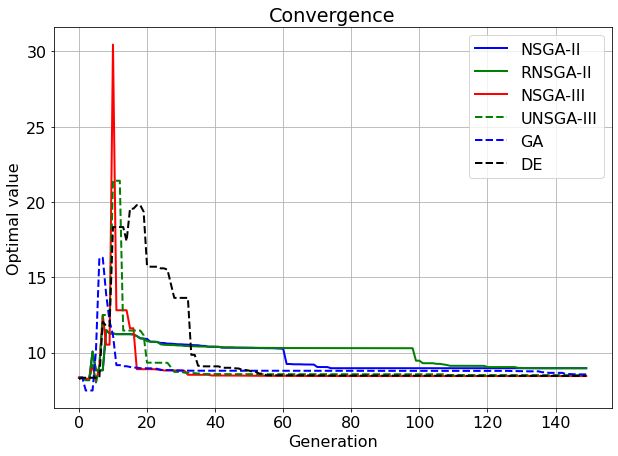

In [ ]:
'''
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["font.size"] = "16"

retNSGA2 = [np.min(e.pop.get("F")) for e in resNSGA2.history]
retRNSGA2 = [np.min(e.pop.get("F")) for e in resRNSGA2.history]
retNSGA3 = [np.min(e.pop.get("F")) for e in resNSGA3.history]
retUNSGA3 = [np.min(e.pop.get("F")) for e in resUNSGA3.history]
retGA = [np.min(e.pop.get("F")) for e in resGA.history]
retDE = [np.min(e.pop.get("F")) for e in resDE.history]

plt.grid(which = 'both') 
plt.plot(np.arange(len(retNSGA2)), retNSGA2, 'b-', label = 'NSGA-II', lw = 2)
plt.plot(np.arange(len(retRNSGA2)), retRNSGA2,'g-', label = 'RNSGA-II', lw = 2)
plt.plot(np.arange(len(retNSGA3)), retNSGA3,'r-', label = 'NSGA-III', lw = 2)
plt.plot(np.arange(len(retUNSGA3)), retUNSGA3,'g--', label = 'UNSGA-III', lw = 2)
plt.plot(np.arange(len(retGA)), retGA,'b--', label = 'GA', lw = 2)
plt.plot(np.arange(len(retDE)), retDE,'k--', label = 'DE', lw = 2)

plt.title("Convergence")
plt.xlabel("Generation")
plt.ylabel("Optimal value")
plt.legend(loc = 'best')
plt.show()
'''

### Circle controller [1]

In [ ]:
def createCircleControllerWithGain(ChromosomeCir,omega_ri, vri, lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
  def controller(t, currentState, destinationState):
    currentX = currentState[0]
    currentY = currentState[1]
    currentTheta = currentState[2]

    destinationX = destinationState[0]
    destinationY = destinationState[1]

    cosTheta = cos(currentTheta)
    sinTheta = sin(currentTheta)

    deltaX = destinationX - currentX
    deltaY = destinationY - currentY

    velocity = vri
    omega = -2 * ChromosomeCir[0] * vri * (deltaX * sinTheta - deltaY * cosTheta) / (deltaX * deltaX + deltaY * deltaY)
    
    if velocity > highVelocityLimit:
      velocity = highVelocityLimit
    if (velocity < lowVelocityLimit):
      velocity = lowVelocityLimit
    if omega > highOmegaLimit:
      omega = highOmegaLimit
    if (omega < lowOmegaLimit):
      omega = lowOmegaLimit

    return velocity, omega
  return controller

### Robins Mathew based controller [1]


In [ ]:
def createController_By_RobinsMathew(chromosomeRM,omega_ri, vri, lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
                                     
  def controller(t, currentState, destinationState):
    currentX = currentState[0]
    currentY = currentState[1]
    currentTheta = currentState[2]

    destinationX = destinationState[0]
    destinationY = destinationState[1]

    cosTheta = cos(currentTheta)
    sinTheta = sin(currentTheta)
    
    deltaX = destinationX - currentX
    deltaY = destinationY - currentY
    theta_destination = atan2(deltaY, deltaX)
    theta_error = theta_destination - currentTheta

    Te = math.sin(theta_destination)*deltaX - math.cos(theta_destination)*deltaY
    
    velocity = vri*math.cos(theta_error)
    omega = omega_ri + chromosomeRM[0]*vri*Te + chromosomeRM[1]*vri*math.sin(theta_error)

    if velocity > highVelocityLimit:
      velocity = highVelocityLimit
    if (velocity < lowVelocityLimit):
      velocity = lowVelocityLimit
    if omega > highOmegaLimit:
      omega = highOmegaLimit
    if (omega < lowOmegaLimit):
      omega = lowOmegaLimit
      
    return velocity, omega
  return controller

### Fuzzy logic controller

In [ ]:

def Fuzzy_control(Chromosome, omega_ri, vri, lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
    inputsDistance = {'VC': [0, 0, Chromosome[0]], 'C': [Chromosome[2]-Chromosome[1], Chromosome[2], Chromosome[2]+Chromosome[3]],
                       'M': [Chromosome[5]-Chromosome[4], Chromosome[5], Chromosome[5]+Chromosome[6]],
                       'F': [Chromosome[8]-Chromosome[7],Chromosome[8], Chromosome[8]+Chromosome[9]], 'VF': [2-Chromosome[10], 2, 2]}
    inputsSpaceDistance = np.array(fitnessFunctionDescription['fuzzyDescription']['inputs']['distance']['S'])
    inputsAngle = {'BN': [-3.14, -3.14, -3.14+Chromosome[11]], 'N': [Chromosome[13]-Chromosome[12], Chromosome[13], Chromosome[13]+Chromosome[14]],
                    'Z': [Chromosome[16]-Chromosome[15], Chromosome[16], Chromosome[16]+Chromosome[17]], 'P': [Chromosome[19]-Chromosome[18], Chromosome[19], Chromosome[19]+Chromosome[20]], 
                    'BP': [3.14-Chromosome[21], 3.14, 3.14]}
    inputsSpaceAngle = np.array(fitnessFunctionDescription['fuzzyDescription']['inputs']['angle']['S'])
    outputsOmegaR = {'VSR': [0, 0, Chromosome[22]], 'SR': [Chromosome[24]-Chromosome[23], Chromosome[24], Chromosome[24]+Chromosome[25]],
                      'MBR': [Chromosome[27]-Chromosome[26], Chromosome[27], Chromosome[27]+Chromosome[28]], 
                      'BR': [Chromosome[30]-Chromosome[29], Chromosome[30], Chromosome[30]+Chromosome[31]], 'VBR': [30-Chromosome[32], 30, 30]}
    outputSpaceOmegaR = np.array(fitnessFunctionDescription['fuzzyDescription']['outputs']['omegaR']['S'])
    outputsOmegaL = {'VSL': [0, 0, Chromosome[33]], 'SL': [Chromosome[35]-Chromosome[34], Chromosome[35], Chromosome[35]+Chromosome[36]],
                      'MBL': [Chromosome[38]-Chromosome[37], Chromosome[38], Chromosome[38]+Chromosome[39]], 
                      'BL': [Chromosome[41]-Chromosome[40], Chromosome[41], Chromosome[41]+Chromosome[42]], 'VBL': [30-Chromosome[43], 30, 30]}
    outputSpaceOmegaL = np.array(fitnessFunctionDescription['fuzzyDescription']['outputs']['omegaL']['S'])
    outputRulesOmegaR = {
      'VC': {'BN': 'VSR', 'N': 'SR', 'Z': 'VSR', 'P': 'BR', 'BP': 'VBR'},
      'C': {'BN': 'VSR', 'N': 'SR', 'Z': 'SR', 'P': 'BR', 'BP': 'VBR'},
      'M': {'BN': 'VSR', 'N': 'SR', 'Z': 'MBR', 'P': 'BR', 'BP': 'VBR'},
      'F': {'BN': 'VSR', 'N': 'SR', 'Z': 'BR', 'P': 'BR', 'BP': 'VBR'},
      'VF': {'BN': 'VSR', 'N': 'SR', 'Z': 'VBR', 'P': 'BR', 'BP': 'VBR'}
    }
    outputRulesOmegaL = {
      'VC': {'BN': 'VBL', 'N': 'BL', 'Z': 'VSL', 'P': 'SL', 'BP': 'VSL'},
      'C': {'BN': 'VBL', 'N': 'BL', 'Z': 'SL', 'P': 'SL', 'BP': 'VSL'},
      'M': {'BN': 'VBL', 'N': 'BL', 'Z': 'MBL', 'P': 'SL', 'BP': 'VSL'},
      'F': {'BN': 'VBL', 'N': 'BL', 'Z': 'BL', 'P': 'SL', 'BP': 'VSL'},
      'VF': {'BN': 'VBL', 'N': 'BL', 'Z': 'VBL', 'P': 'SL', 'BP': 'VSL'}
    }
    def createFuzzyfier(space, categories, trimf = fuzz.trimf, membership = fuzz.interp_membership):
      fuzzyInput = {}
      for key, value in categories.items():
        fuzzyInput[key] = trimf(space, value)
      def result(variable):
        output = {}
        for key, value in fuzzyInput.items():
          output[key] = membership(space, value, variable)
        if output[key] ==0:
          output[key] = 1e-5
        else:
          output[key] = output[key] 
        return output
      return result
    def createInferenceSystem(inputAfuzzyfier, inputBfuzzyfier, outputSpace, outputDict, rulesDict, trimf = fuzz.trimf):
      fuzzyResults = {}
      for keyA, outerValue in rulesDict.items():
        if not(keyA in fuzzyResults):
          fuzzyResults[keyA] = {}
        for keyB, innerValue in outerValue.items():
          fuzzyResults[keyA][keyB] = trimf(outputSpace, outputDict[innerValue]) #innerValue==outputDict[keyA][keyB]
      def result(valueA, valueB):
        fuzzyVariableA = inputAfuzzyfier(valueA)
        fuzzyVariableB = inputBfuzzyfier(valueB)
        fuzzyResult = None
        for keyA, outerValue in rulesDict.items():
          for keyB, resultValue in outerValue.items():
            currentResult = np.fmin(fuzzyResults[keyA][keyB],
                np.fmin(fuzzyVariableA[keyA], fuzzyVariableB[keyB]))
            if fuzzyResult is None:
              fuzzyResult = currentResult
            else:
              fuzzyResult = np.fmax(currentResult, fuzzyResult)
        return fuzzyResult
      return result
    def createDefuzzyfier(outputSpace, *defuzzArgs, defuzz=fuzz.defuzz, **defuzzKwargs):
      def result(value):
        return defuzz(outputSpace, value, *defuzzArgs, **defuzzKwargs)
      return result
    def createFullFuzzySystem(inferenceSystem, defuzzyfier):
      def system(inputA, inputB):
        return defuzzyfier(inferenceSystem(inputA, inputB))
      return system

    inputsDistanceFuzzyfier = createFuzzyfier(inputsSpaceDistance, inputsDistance)
    inputsAngleFuzzyfier = createFuzzyfier(inputsSpaceAngle, inputsAngle)

    inferenceSystem_R = createInferenceSystem(inputsDistanceFuzzyfier, inputsAngleFuzzyfier, outputSpaceOmegaR, outputsOmegaR, outputRulesOmegaR)
    outputDefuzzyfier_R = createDefuzzyfier(outputSpaceOmegaL, mode='centroid')

    inferenceSystem_L = createInferenceSystem(inputsDistanceFuzzyfier, inputsAngleFuzzyfier, outputSpaceOmegaL, outputsOmegaL, outputRulesOmegaL)
    outputDefuzzyfier_L = createDefuzzyfier(outputSpaceOmegaL, mode='centroid')

    fullSystem_R = createFullFuzzySystem(inferenceSystem_R, outputDefuzzyfier_R)
    fullSystem_L = createFullFuzzySystem(inferenceSystem_L, outputDefuzzyfier_L)
    
    def controller(t, currentState, destinationState):
        currentX = currentState[0]
        currentY = currentState[1]
        currentTheta = currentState[2]

        destinationX = destinationState[0]
        destinationY = destinationState[1]

        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)
        
        deltaX = destinationX - currentX
        deltaY = destinationY - currentY
        theta_destination = atan2(deltaY, deltaX)
        THETA_ERROR = theta_destination - currentTheta
        DISTANCE_ERROR = sqrt(deltaX * deltaX + deltaY * deltaY)
        
        if (THETA_ERROR > pi):
          THETA_ERROR -= 2*pi
        if (THETA_ERROR < -pi):
          THETA_ERROR += 2*pi
      
        omega_R = fullSystem_R(DISTANCE_ERROR, THETA_ERROR)
        omega_L = fullSystem_L(DISTANCE_ERROR, THETA_ERROR)

        velocity = fitnessFunctionDescription['robotParams']['r']*(omega_R + omega_L)/2
        omega = fitnessFunctionDescription['robotParams']['r']*(omega_R - omega_L)/fitnessFunctionDescription['robotParams']['b']

        if velocity > highVelocityLimit:
            velocity = highVelocityLimit
        if (velocity < lowVelocityLimit):
            velocity = lowVelocityLimit
        if omega > highOmegaLimit:
            omega = highOmegaLimit
        if (omega < lowOmegaLimit):
            omega = lowOmegaLimit

        return velocity, omega
    return controller

### Colecting results to plot

In [ ]:
Best_Chromosome = [ 1.09064615,  1.08820085,  0.50773892,  1.9404956,   0.45578745,  0.89506371,
  1.0215489,   1.15103391,  1.48824193,  0.09975203,  1.99025819,  3.51661487,
  1.30826502, -1.48187475,  0.09987379,  1.24934221, -0.48782162,  0.32973276,
  1.83830671,  1.70642736,  1.90527504,  2.13031687, 14.11711448,  5.96295695,
  8.3225772,  15.41387028, 16.75280818, 15.03114383,  6.6485569,  20.86535937,
 24.77442465, 25.40147806, 22.29248669, 11.81221656, 20.11888457,  5.4514414,
 20.15453731, 19.89003594, 17.21176476, 16.28769668,  3.99707514, 28.33114048,
 20.17102109, 12.42956111]

def controllerUsingGenes_FLC(pathForSimulation):
  t0 = 0
  t_bound = 40
  max_step = 0.05
  state0 = None
  if robot == robotWithDynamic:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0, 0, 0, 0, 0]) # x0=0, y0=0, theta
  else:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0]) # x0=0, y0=0,theta

  solverfunc = simpleCompute(
      compute, state0 = state0, 
      t0 = t0, t_bound = t_bound, max_step = max_step)
 
  #--------------------for Fuzzy and GA_FLC-------------------------------------------------  
  def controllerForGenes_Fuzzy(chromosome_Fuzzy):
    def transformGeneIntoControllerParams(chromosome_Fuzzy):    
      controllerParams_Fuzzy = {'Chromosome':chromosome_Fuzzy, 'omega_ri':fitnessFunctionDescription['controllerParams']['omega_ri'],
                                'vri':fitnessFunctionDescription['controllerParams']['vri'], 
                                'lowVelocityLimit':fitnessFunctionDescription['controllerParams']['lowVelocityLimit'], 
                                'highVelocityLimit':fitnessFunctionDescription['controllerParams']['highVelocityLimit'],
                                'lowOmegaLimit':fitnessFunctionDescription['controllerParams']['lowOmegaLimit'],
                                'highOmegaLimit':fitnessFunctionDescription['controllerParams']['highOmegaLimit']}     
      return controllerParams_Fuzzy

    createController_Fuzzy = Fuzzy_control

    def createRobot():
      controllerParams_Fuzzy = transformGeneIntoControllerParams(chromosome_Fuzzy)
      robot = robotModelCreator(createController_Fuzzy, pathForSimulation, **controllerParams_Fuzzy)      
      return robot

    def runSimulation(robot):
      robotStates = solverfunc(robot)
      velocitys = []
      omegas = []
      timeStep = []
      x_axis = []
      y_axis = []
      s = []
      E = []
      for currentState in robotStates: # readout all states from current moving robot
        velocity = currentState['dy'][3]
        velocitys.append(velocity)
        omega = currentState['dy'][4]
        omegas.append(omega)
        time = currentState['time']
        timeStep.append(time)
        x = currentState['y'][0]
        x_axis.append(x)
        y = currentState['y'][1]
        y_axis.append(y)
        s_step = currentState['y'][3]
        s.append(s_step)
        E_step = currentState['TotalEnergy']       
        E.append(E_step)
      return velocitys, omegas, timeStep, x_axis, y_axis, s, E

    robot = createRobot()
    velocitys, omegas, timeStep, x_axis, y_axis, s, E = runSimulation(robot)

    return velocitys, omegas, timeStep, x_axis, y_axis, s, E
  return controllerForGenes_Fuzzy
#-------call function to get results for FLC only---------------------------------------------
controllerForGenes_Fuzzy = controllerUsingGenes_FLC(iter(fitnessFunctionDescription['path']))
chromosome_Fuzzy = [1,1,1,1,1,2,1,1,3,1,1,  1.57,1.57,-1.57,1.57,1.57,0,1.57,1.57,1.57,1.57,1.57,  
                    7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5]
results_Fuzzy = controllerForGenes_Fuzzy(chromosome_Fuzzy)
#------- get results to plot ---------------------------------------------------
# data for Fuzzy control
velocity_Fuzzy = results_Fuzzy[0]
omega_Fuzzy = results_Fuzzy[1]
time_Fuzzy = results_Fuzzy[2]
x_Fuzzy = results_Fuzzy[3]
y_Fuzzy = results_Fuzzy[4]
s_Fuzzy = results_Fuzzy[5]
E_Fuzzy = results_Fuzzy[6]
print('E_Fuzzy =',E_Fuzzy[-1])
print('s_Fuzzy =',s_Fuzzy[-1])
#-------call function to get results for GA_FLC---------------------------------------------
controllerForGenes_Fuzzy_GA = controllerUsingGenes_FLC(iter(fitnessFunctionDescription['path']))
chromosome_Fuzzy_GA = Best_Chromosome
results_Fuzzy_GA = controllerForGenes_Fuzzy_GA(chromosome_Fuzzy_GA)
#------- get results to plot ---------------------------------------------------
# data for Fuzzy_GA control
velocity_Fuzzy_GA = results_Fuzzy_GA[0]
omega_Fuzzy_GA = results_Fuzzy_GA[1]
time_Fuzzy_GA = results_Fuzzy_GA[2]
x_Fuzzy_GA = results_Fuzzy_GA[3]
y_Fuzzy_GA = results_Fuzzy_GA[4]
s_Fuzzy_GA = results_Fuzzy_GA[5]
E_Fuzzy_GA = results_Fuzzy_GA[6]
print('E_Fuzzy_GA =',E_Fuzzy_GA[-1])
print('s_Fuzzy_GA =',s_Fuzzy_GA[-1])

E_Fuzzy = 108.91173359195095
s_Fuzzy = 38.671612837188434
E_Fuzzy_GA = 8.436189879969762
s_Fuzzy_GA = 39.04802534792088


In [ ]:

def controllerUsingGenes_RM(pathForSimulation):
  t0 = 0
  t_bound = 40
  max_step = 0.05
  state0 = None
  if robot == robotWithDynamic:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0, 0, 0, 0, 0]) # x0=0, y0=0, theta
  else:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0]) # x0=0, y0=0,theta

  solverfunc = simpleCompute(
      compute, state0 = state0, 
      t0 = t0, t_bound = t_bound, max_step = max_step) 
  #--------------------for Robins Mathew-------------------------------------------------  
  def controllerForGenes_RM(chromosome_RM):
    def transformGeneIntoControllerParams(chromosome_RM):    
      controllerParams_RM = {'chromosomeRM':chromosome_RM, 'omega_ri':fitnessFunctionDescription['controllerParams']['omega_ri'],
                                'vri':fitnessFunctionDescription['controllerParams']['vri'], 
                                'lowVelocityLimit':fitnessFunctionDescription['controllerParams']['lowVelocityLimit'], 
                                'highVelocityLimit':fitnessFunctionDescription['controllerParams']['highVelocityLimit'],
                                'lowOmegaLimit':fitnessFunctionDescription['controllerParams']['lowOmegaLimit'],
                                'highOmegaLimit':fitnessFunctionDescription['controllerParams']['highOmegaLimit']}     
      return controllerParams_RM

    createController_RM = createController_By_RobinsMathew

    def createRobot_RM():
      controllerParams_RM = transformGeneIntoControllerParams(chromosome_RM)
      robot = robotModelCreator(createController_RM, pathForSimulation, **controllerParams_RM)      
      return robot

    def runSimulation(robot):
      robotStates = solverfunc(robot)
      velocitys = []
      omegas = []
      timeStep = []
      x_axis = []
      y_axis = []
      s = []
      E = []
      for currentState in robotStates: # readout all states from current moving robot
        velocity = currentState['dy'][3]
        velocitys.append(velocity)
        omega = currentState['dy'][4]
        omegas.append(omega)
        time = currentState['time']
        timeStep.append(time)
        x = currentState['y'][0]
        x_axis.append(x)
        y = currentState['y'][1]
        y_axis.append(y)
        s_step = currentState['y'][3]
        s.append(s_step)
        E_step = currentState['TotalEnergy']       
        E.append(E_step)
      return velocitys, omegas, timeStep, x_axis, y_axis, s, E

    robot = createRobot_RM()
    velocitys, omegas, timeStep, x_axis, y_axis, s, E = runSimulation(robot)

    return velocitys, omegas, timeStep, x_axis, y_axis, s, E
  return controllerForGenes_RM
#-------call function to get result---------------------------------------------
controllerForGenes_Mathew = controllerUsingGenes_RM(iter(fitnessFunctionDescription['path']))
chromosome_Mathew = [1.5, 6.5]
results_Mathew = controllerForGenes_Mathew(chromosome_Mathew)
#------- get results to plot ---------------------------------------------------
# data for RobinsMathew control
velocity_Mathew = results_Mathew[0]
omega_Mathew = results_Mathew[1]
time_Mathew = results_Mathew[2]
x_Mathew = results_Mathew[3]
y_Mathew = results_Mathew[4]
s_Mathew = results_Mathew[5]
E_Mathew = results_Mathew[6]

print('E_Mathew =', E_Mathew[-1])
print('travel distance Mathew = ',s_Mathew[-1])


E_Mathew = 23.852355320815956
travel distance Mathew =  38.97461209126093


In [ ]:

def controllerUsingGenes_Cir(pathForSimulation):
  t0 = 0
  t_bound = 40
  max_step = 0.05
  state0 = None
  if robot == robotWithDynamic:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0, 0, 0, 0, 0]) # x0=0, y0=0, theta
  else:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0]) # x0=0, y0=0,theta

  solverfunc = simpleCompute(
      compute, state0 = state0, 
      t0 = t0, t_bound = t_bound, max_step = max_step) 
  
  #--------------------for Circle based controller-------------------------------------------------  
  def controllerForGenes_Cir(chromosome_Cir):
    def transformGeneIntoControllerParams(chromosome_Cir):    
      controllerParams_Cir = {'ChromosomeCir':chromosome_Cir, 'omega_ri':fitnessFunctionDescription['controllerParams']['omega_ri'],
                                'vri':fitnessFunctionDescription['controllerParams']['vri'], 
                                'lowVelocityLimit':fitnessFunctionDescription['controllerParams']['lowVelocityLimit'], 
                                'highVelocityLimit':fitnessFunctionDescription['controllerParams']['highVelocityLimit'],
                                'lowOmegaLimit':fitnessFunctionDescription['controllerParams']['lowOmegaLimit'],
                                'highOmegaLimit':fitnessFunctionDescription['controllerParams']['highOmegaLimit']}     
      return controllerParams_Cir

    createController_Cir = createCircleControllerWithGain

    def createRobot_Cir():
      controllerParams_Cir = transformGeneIntoControllerParams(chromosome_Cir)
      robot = robotModelCreator(createController_Cir, pathForSimulation, **controllerParams_Cir)      
      return robot
    def runSimulation(robot):
      robotStates = solverfunc(robot)
      velocitys = []
      omegas = []
      timeStep = []
      x_axis = []
      y_axis = []
      s = []
      E = []
      for currentState in robotStates: # readout all states from current moving robot
        velocity = currentState['dy'][3]
        velocitys.append(velocity)
        omega = currentState['dy'][4]
        omegas.append(omega)
        time = currentState['time']
        timeStep.append(time)
        x = currentState['y'][0]
        x_axis.append(x)
        y = currentState['y'][1]
        y_axis.append(y)
        s_step = currentState['y'][3]
        s.append(s_step)
        E_step = currentState['TotalEnergy']       
        E.append(E_step)
      return velocitys, omegas, timeStep, x_axis, y_axis, s, E
    robot = createRobot_Cir()
    velocitys, omegas, timeStep, x_axis, y_axis, s, E = runSimulation(robot)
    return velocitys, omegas, timeStep, x_axis, y_axis, s, E
  return controllerForGenes_Cir

#-------call function to get result---------------------------------------------
controllerForGenes_Cir = controllerUsingGenes_Cir(iter(fitnessFunctionDescription['path']))
chromosome_Cir = [4, 0]
results_Cir = controllerForGenes_Cir(chromosome_Cir)
#------- get results to plot ---------------------------------------------------
# data for RobinsMathew control
velocity_Cir = results_Cir[0]
omega_Cir = results_Cir[1]
time_Cir = results_Cir[2]
x_Cir = results_Cir[3]
y_Cir = results_Cir[4]
s_Cir = results_Cir[5]
E_Cir = results_Cir[6]

print('E_Cir =', E_Cir[-1])
print('travel distance Cir = ',s_Cir[-1])


E_Cir = 17.676678090426915
travel distance Cir =  39.308766763336585


In [ ]:
# data for path
pathx = []
pathy = []
for x, y, orientation in fitnessFunctionDescription['path']:
  pathx.append(x)
  pathy.append(y)

### Ploting all results

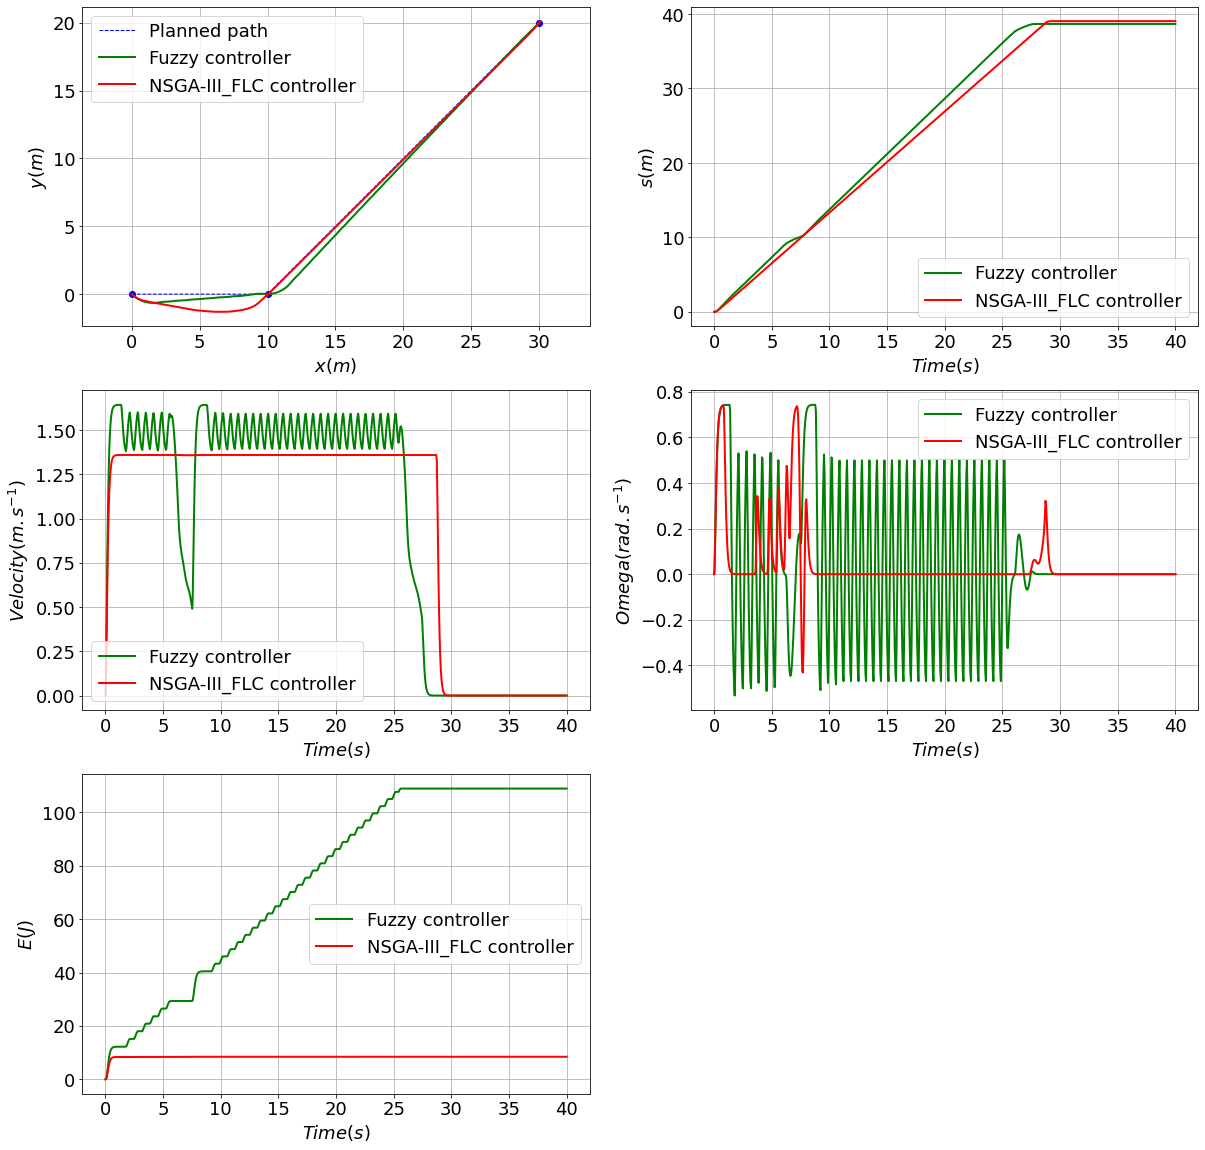

In [ ]:
plt.rcParams["figure.figsize"] = (20, 20)
plt.rcParams["font.size"] = "18"

#--plot the path--------------------------------------------------------------
plt.subplot(3,2,1)
plt.grid(which = 'both') 
p = plt.axis('equal')
plt.plot(0, 0, 'bo',lw = 30)
plt.plot(10, 0, 'bo',lw = 30)
plt.plot(30, 20, 'bo',lw = 30)
plt.plot(pathx, pathy, 'b--', label = 'Planned path', lw = 1)
#plt.plot(x_Cir, y_Cir, 'k-.', label = 'Circle controller', lw = 1)
#plt.plot(x_Mathew, y_Mathew, 'g--', label = 'Mathew controller', lw = 1)
plt.plot(x_Fuzzy, y_Fuzzy, 'g-', label = 'Fuzzy controller', lw = 2)
plt.plot(x_Fuzzy_GA, y_Fuzzy_GA, 'r-', label = 'NSGA-III_FLC controller', lw = 2)
plt.legend(loc = 'best')
plt.xlabel('$x(m)$')
plt.ylabel('$y(m)$')

def plotVal(n, t1, t2, val1, val2, lable):
  plt.subplot(3,2,n)
  plt.grid(which = 'both') 
  plt.plot(t1, val1, 'g-', label = 'Fuzzy controller', lw = 2)
  plt.plot(t2, val2, 'r-', label = 'NSGA-III_FLC controller', lw = 2)
  #plt.plot(t3, val3, 'k-.', label = 'Circle controller', lw = 1)
  #plt.plot(t4, val4, 'g--', label = 'Mathew controller', lw = 1)
  plt.legend(loc = 'best')
  plt.xlabel('$Time(s)$')
  plt.ylabel(lable)
  return

#--plot the travel distance----------------------------------------------------
plotVal(2,time_Fuzzy,time_Fuzzy_GA,s_Fuzzy,s_Fuzzy_GA,'$s(m)$')

#---plot the velocity----------------------------------------------------------
plotVal(3,time_Fuzzy,time_Fuzzy_GA,velocity_Fuzzy,velocity_Fuzzy_GA,'$Velocity(m.s^{-1})$')

#--plot the omega-------------------------------------------------------------
plotVal(4,time_Fuzzy,time_Fuzzy_GA, omega_Fuzzy,omega_Fuzzy_GA,'$Omega(rad.s^{-1})$')

#--plot the total energy consumption------------------------------------------
plotVal(5,time_Fuzzy,time_Fuzzy_GA,E_Fuzzy,E_Fuzzy_GA,'$E(J)$')

### Ploting all membership functions

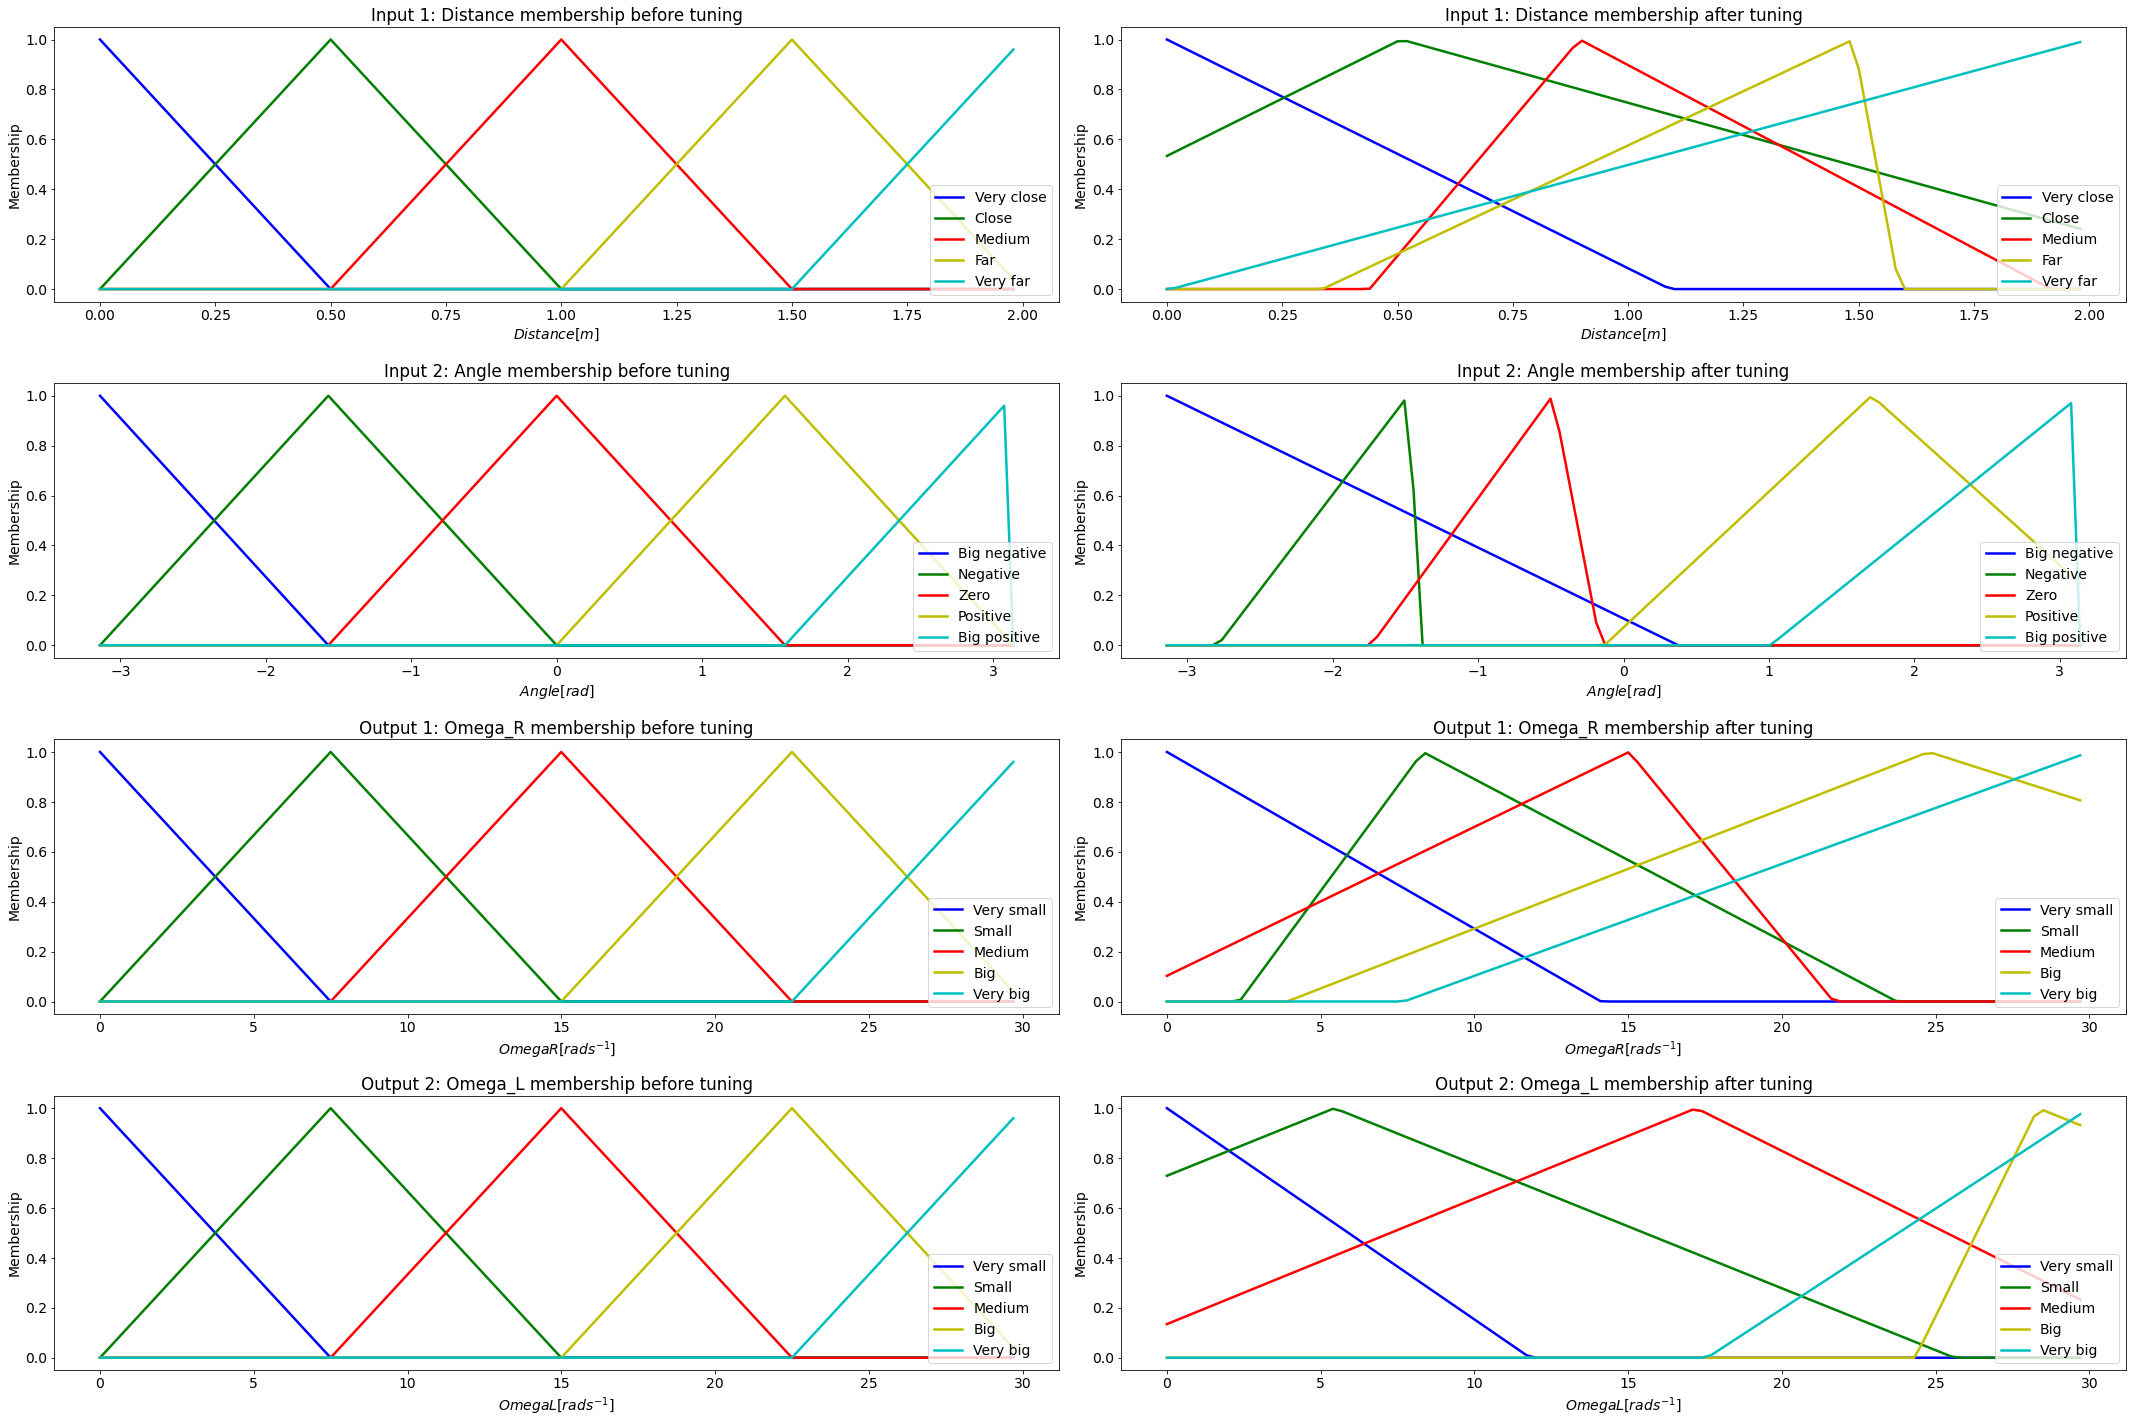

In [ ]:
Chromosome = Best_Chromosome
omega = np.array(fitnessFunctionDescription['fuzzyDescription']['outputs']['omegaR']['S'])
distance = np.array(fitnessFunctionDescription['fuzzyDescription']['inputs']['distance']['S'])
angle = np.array(fitnessFunctionDescription['fuzzyDescription']['inputs']['angle']['S'])

# Membership functions for inputs
# Before tuning
VC = fuzz.trimf(distance, [0,0,0.5])
C = fuzz.trimf(distance, [0,0.5,1])
M = fuzz.trimf(distance, [0.5,1,1.5])
F = fuzz.trimf(distance, [1,1.5,2])
VF = fuzz.trimf(distance, [1.5,2,2])

BN = fuzz.trimf(angle, [-3.14,-3.14,-1.57])
N = fuzz.trimf(angle, [-3.14,-1.57,0])
Z = fuzz.trimf(angle, [-1.57,0,1.57])
P = fuzz.trimf(angle, [0,1.57,3.14])
BP = fuzz.trimf(angle, [1.57,3.14,3.14])
# After tuning
VC1 = fuzz.trimf(distance, [0, 0, Chromosome[0]])
C1 = fuzz.trimf(distance, [Chromosome[2]-Chromosome[1], Chromosome[2], Chromosome[2]+Chromosome[3]])
M1 = fuzz.trimf(distance, [Chromosome[5]-Chromosome[4], Chromosome[5], Chromosome[5]+Chromosome[6]])
F1 = fuzz.trimf(distance, [Chromosome[8]-Chromosome[7],Chromosome[8], Chromosome[8]+Chromosome[9]])
VF1 = fuzz.trimf(distance, [2-Chromosome[10], 2, 2])

BN1 = fuzz.trimf(angle, [-3.14, -3.14, -3.14+Chromosome[11]])
N1 = fuzz.trimf(angle, [Chromosome[13]-Chromosome[12], Chromosome[13], Chromosome[13]+Chromosome[14]])
Z1 = fuzz.trimf(angle, [Chromosome[16]-Chromosome[15], Chromosome[16], Chromosome[16]+Chromosome[17]])
P1 = fuzz.trimf(angle, [Chromosome[19]-Chromosome[18], Chromosome[19], Chromosome[19]+Chromosome[20]])
BP1 = fuzz.trimf(angle, [3.14-Chromosome[21], 3.14, 3.14])

# Membership functions for outputs
# Before tuning
VS_R = fuzz.trimf(omega, [0, 0, 7.5])
S_R = fuzz.trimf(omega, [0, 7.5, 15])
MB_R = fuzz.trimf(omega, [7.5, 15, 22.5])
B_R = fuzz.trimf(omega, [15, 22.5, 30])
VB_R = fuzz.trimf(omega, [22.5, 30, 30])

# After tuning
VS_R1 = fuzz.trimf(omega, [0, 0, Chromosome[22]])
S_R1 = fuzz.trimf(omega, [Chromosome[24]-Chromosome[23], Chromosome[24], Chromosome[24]+Chromosome[25]])
MB_R1 = fuzz.trimf(omega, [Chromosome[27]-Chromosome[26], Chromosome[27], Chromosome[27]+Chromosome[28]])
B_R1 = fuzz.trimf(omega, [Chromosome[30]-Chromosome[29], Chromosome[30], Chromosome[30]+Chromosome[31]])
VB_R1 = fuzz.trimf(omega, [30-Chromosome[32], 30, 30])

VS_L = fuzz.trimf(omega, [0, 0, Chromosome[33]])
S_L = fuzz.trimf(omega, [Chromosome[35]-Chromosome[34], Chromosome[35], Chromosome[35]+Chromosome[36]])
MB_L = fuzz.trimf(omega, [Chromosome[38]-Chromosome[37], Chromosome[38], Chromosome[38]+Chromosome[39]])
B_L = fuzz.trimf(omega, [Chromosome[41]-Chromosome[40], Chromosome[41], Chromosome[41]+Chromosome[42]])
VB_L = fuzz.trimf(omega, [30-Chromosome[43], 30, 30])

#--------------Plot----------------------------------------
plt.rcParams["figure.figsize"] = (30, 20)
plt.rcParams["font.size"] = "14"

def plotMember(range, val, lab,i,title):
  plt.subplot(4,2,i)
  plt.tight_layout() 
  plt.plot(range, val[0], 'b', linewidth=2.5, label=lab[0])
  plt.plot(range, val[1], 'g', linewidth=2.5, label=lab[1])
  plt.plot(range, val[2], 'r', linewidth=2.5, label=lab[2])
  plt.plot(range, val[3], 'y', linewidth=2.5, label=lab[3])
  plt.plot(range, val[4], 'c', linewidth=2.5, label=lab[4])
  plt.title(title[0])
  plt.ylabel('Membership')
  plt.xlabel(title[1])
  plt.legend(loc = 'lower right')
  return

#----Input_1: Distance member ship before tuning------------
val = [VC,C,M,F,VF]
lab = ['Very close', 'Close', 'Medium', 'Far', 'Very far']
title = ['Input 1: Distance membership before tuning', '$Distance[m]$']
plotMember(distance, val, lab,1,title)

#----Input_1: Distance member ship after tuning------------
val = [VC1,C1,M1,F1,VF1]
lab = ['Very close', 'Close', 'Medium', 'Far', 'Very far']
title = ['Input 1: Distance membership after tuning', '$Distance[m]$']
plotMember(distance, val, lab, 2, title)

#----Input_2: Angle member ship before tuning------------
val = [BN,N,Z,P,BP]
lab = ['Big negative', 'Negative', 'Zero', 'Positive', 'Big positive']
title = ['Input 2: Angle membership before tuning', '$Angle[rad]$']
plotMember(angle, val, lab, 3, title)

#----Input_2: Angle member ship after tuning------------
val = [BN1,N1,Z1,P1,BP1]
lab = ['Big negative', 'Negative', 'Zero', 'Positive', 'Big positive']
title = ['Input 2: Angle membership after tuning', '$Angle[rad]$']
plotMember(angle, val, lab, 4, title)

#----output_1:  Omega_R member ship before tuning------------
val = [VS_R, S_R, MB_R, B_R, VB_R]
lab = ['Very small', 'Small', 'Medium', 'Big', 'Very big']
title = ['Output 1: Omega_R membership before tuning', '$OmegaR[rads^{-1}]$']
plotMember(omega, val, lab, 5, title)

#----output_1:  Omega_R member ship after tuning------------
val = [VS_R1, S_R1, MB_R1, B_R1, VB_R1]
lab = ['Very small', 'Small', 'Medium', 'Big', 'Very big']
title = ['Output 1: Omega_R membership after tuning', '$OmegaR[rads^{-1}]$']
plotMember(omega, val, lab, 6, title)

#----output_2:  Omega_L member ship before tuning------------
val = [VS_R, S_R, MB_R, B_R, VB_R]
lab = ['Very small', 'Small', 'Medium', 'Big', 'Very big']
title = ['Output 2: Omega_L membership before tuning', '$OmegaL[rads^{-1}]$']
plotMember(omega, val, lab, 7, title)

#----output_2:  Omega_L member ship after tuning------------
val = [VS_L, S_L, MB_L, B_L, VB_L]
lab = ['Very small', 'Small', 'Medium', 'Big', 'Very big']
title = ['Output 2: Omega_L membership after tuning', '$OmegaL[rads^{-1}]$']
plotMember(omega, val, lab, 8, title)
